Epoch 1/10
928/928 [==============================] - 9s 6ms/step - loss: 0.0820 - accuracy: 0.9887 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 2/10
928/928 [==============================] - 5s 5ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0019 - val_accuracy: 0.9994
Epoch 3/10
928/928 [==============================] - 8s 9ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 4/10
928/928 [==============================] - 6s 6ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 5/10
928/928 [==============================] - 6s 6ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 6/10
928/928 [==============================] - 5s 5ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 7/10
928/928 [==============================] - 5s 5ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 

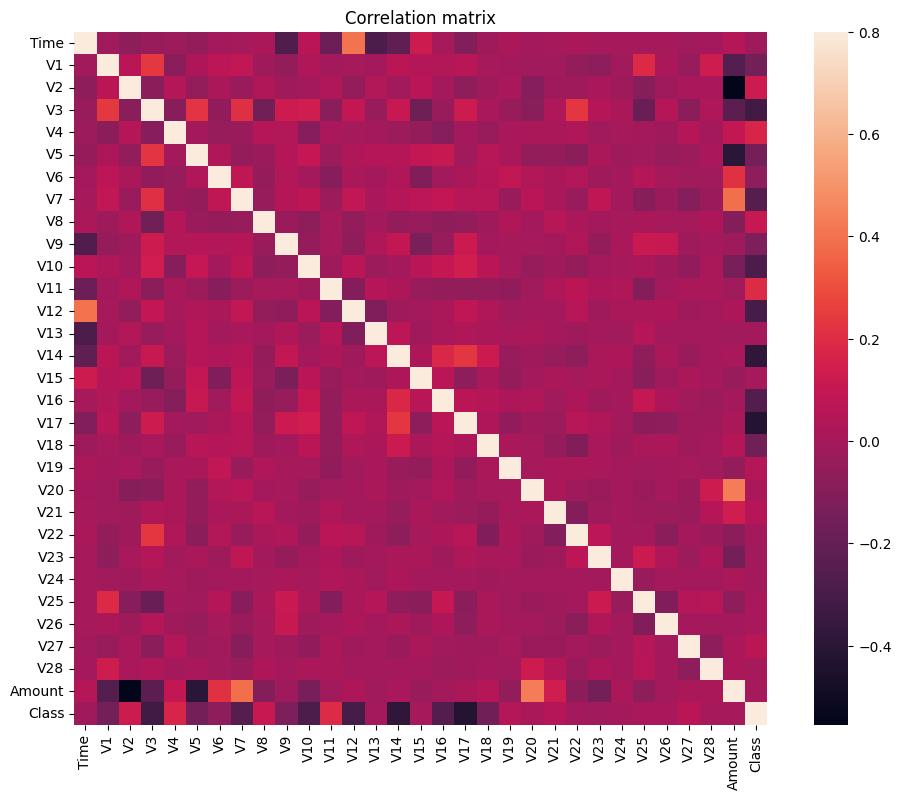

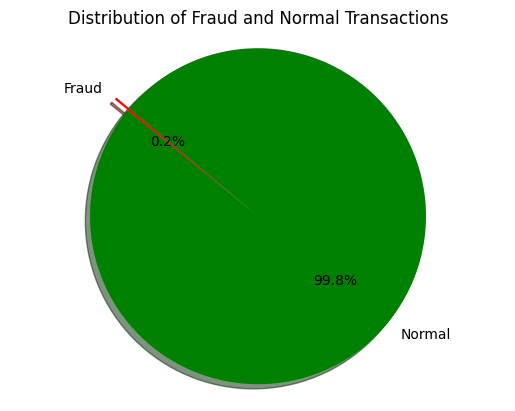

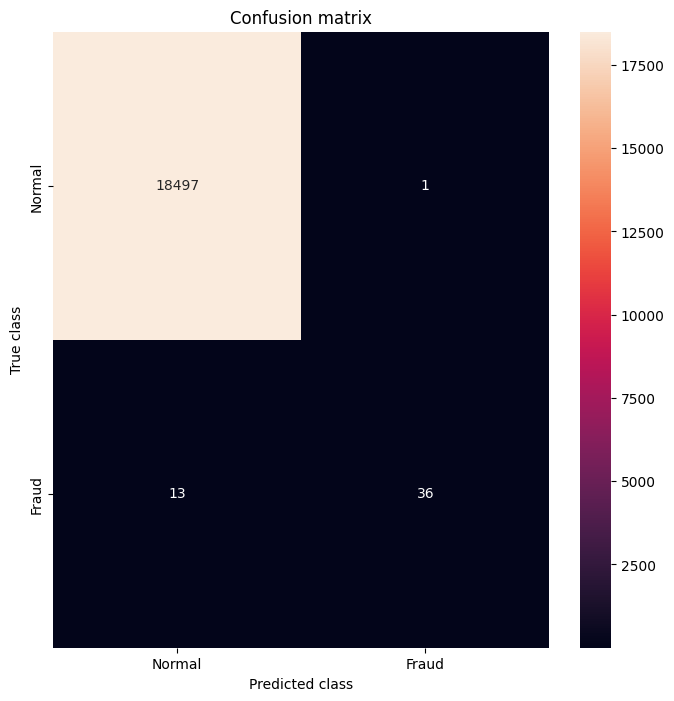

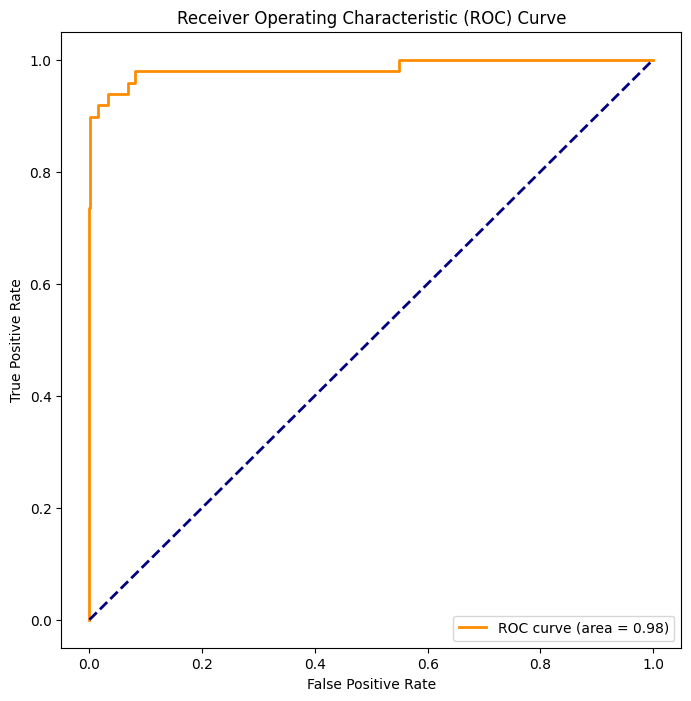

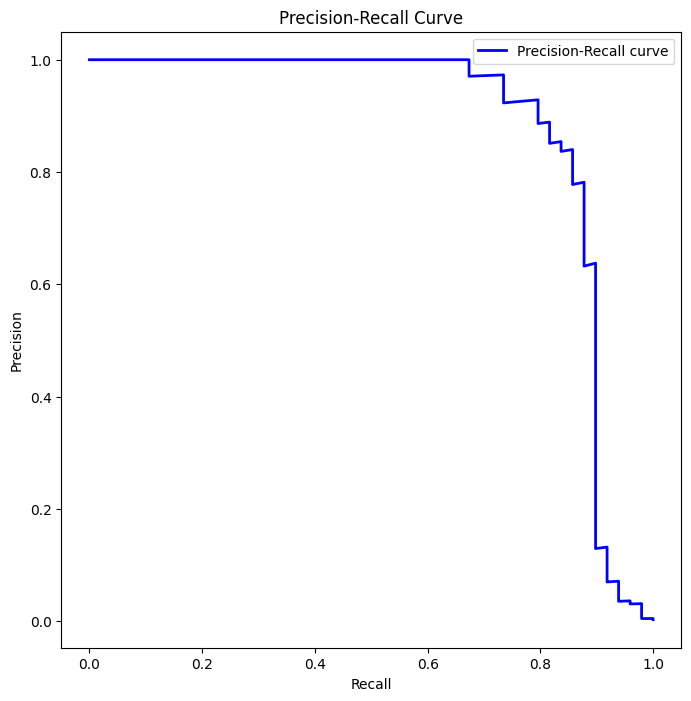

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv("creditcard.csv")

# Separating the X and Y values
X = data.drop(['Class'], axis=1)
Y = data['Class']
xData = X.values
yData = Y.values

# Determine the number of fraud cases in the dataset
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
outlierFraction = len(fraud) / float(len(valid))

# Splitting the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.2, random_state=42)

# Handling missing values using SimpleImputer for features
imputer = SimpleImputer(strategy='mean')
xTrain_imputed = imputer.fit_transform(xTrain)
xTest_imputed = imputer.transform(xTest)

# Handling missing values in the target variable
yTrain = np.nan_to_num(yTrain)
yTest = np.nan_to_num(yTest)

# Standardize the input features
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain_imputed)
xTest_scaled = scaler.transform(xTest_imputed)

# Reshape data for LSTM input
xTrain_lstm = xTrain_scaled.reshape((xTrain_scaled.shape[0], 1, xTrain_scaled.shape[1]))
xTest_lstm = xTest_scaled.reshape((xTest_scaled.shape[0], 1, xTest_scaled.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(xTrain_lstm.shape[1], xTrain_lstm.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(xTrain_lstm, yTrain, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Predictions
yPred_prob = model.predict(xTest_lstm)
yPred = (yPred_prob > 0.5).astype(int)

# Evaluate the classifier
print("The model used is LSTM Neural Network")

acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))

prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))

rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))

f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))

MCC = matthews_corrcoef(yTest, yPred)
print("The Matthews correlation coefficient is {}".format(MCC))

# Visualizing the Correlation Matrix
corrmat = data.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.title("Correlation matrix")
plt.show()

# Visualizing the Fraud and Normal Transaction Distribution (Pie Chart)
labels = 'Fraud', 'Normal'
sizes = [len(fraud), len(valid)]
colors = ['red', 'green']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Distribution of Fraud and Normal Transactions")
plt.show()

# Visualizing the Confusion Matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yPred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(yTest, yPred_prob)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
